# Get dataframe

In [1]:
import pandas as pd

In [2]:
df_main  = pd.read_csv('/home/emilien/code/EmilienStoret/favorita/Data/df_main_V4.csv') 

In [3]:
df_main.head()

,id,date,store_nbr,family,sales,onpromotion,city,holidays,holidays_nat,is_holiday,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,0,1,1,93.14
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,0,1,1,93.14
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,0,1,1,93.14
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,0,1,1,93.14
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,0,1,1,93.14


In [4]:
df = df_main.groupby('date')[['sales','onpromotion']].sum()
df

,sales,onpromotion
date,,
2013-01-01,2511.618999,0
2013-01-02,496092.417944,0
2013-01-03,361461.231124,0
2013-01-04,354459.677093,0
2013-01-05,477350.121229,0
...,...,...
2017-08-11,826373.722022,14179
2017-08-12,792630.535079,8312
2017-08-13,865639.677471,9283


In [5]:
df_oil = df_main.groupby('date')[['dcoilwtico']].mean()
df_oil

,dcoilwtico
date,
2013-01-01,93.14
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-05,93.12
...,...
2017-08-11,48.81
2017-08-12,48.81
2017-08-13,48.81


In [6]:
df1 = df.merge(df_oil[['dcoilwtico']], how='left', left_index=True, right_index=True)
df1

,sales,onpromotion,dcoilwtico
date,,,
2013-01-01,2511.618999,0,93.14
2013-01-02,496092.417944,0,93.14
2013-01-03,361461.231124,0,92.97
2013-01-04,354459.677093,0,93.12
2013-01-05,477350.121229,0,93.12
...,...,...,...
2017-08-11,826373.722022,14179,48.81
2017-08-12,792630.535079,8312,48.81
2017-08-13,865639.677471,9283,48.81


<AxesSubplot: >

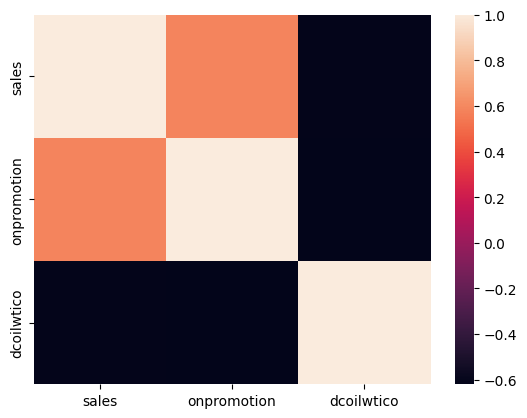

In [7]:
import seaborn as sns

sns.heatmap(df1.corr())

# Impact of oil

In [8]:
!pip install dowhy

In [9]:
import dowhy

In [10]:
causal_graph="""digraph {
sales[label = "sales"];
onpromotion[label = "onpromotion"];
dcoilwtico[label = "dcoilwtico"];
onpromotion -> sales;
dcoilwtico -> sales;
}"""

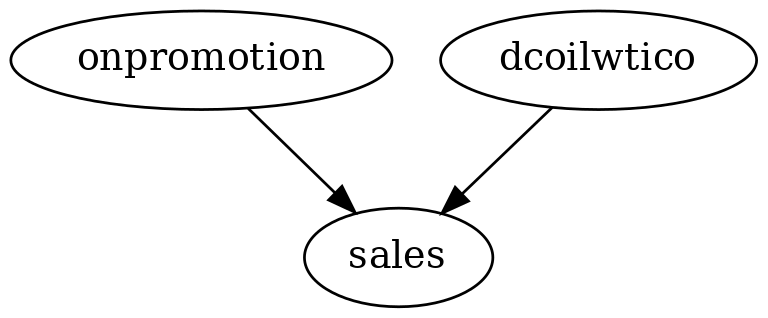

In [11]:
model= dowhy.CausalModel(
        data = df1,
        graph=causal_graph.replace("\n", " "),
        treatment="dcoilwtico",
        outcome='sales')
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [12]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                
─────────────(E[sales])
d[dcoilwtico]          
Estimand assumption 1, Unconfoundedness: If U→{dcoilwtico} and U→sales then P(sales|dcoilwtico,,U) = P(sales|dcoilwtico,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [13]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression")
print(estimate)

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                
─────────────(E[sales])
d[dcoilwtico]          
Estimand assumption 1, Unconfoundedness: If U→{dcoilwtico} and U→sales then P(sales|dcoilwtico,,U) = P(sales|dcoilwtico,)

## Realized estimand
b: sales~dcoilwtico+dcoilwtico*onpromotion
Target units: ate

## Estimate
Mean value: -2724.128396106302
### Conditional Estimates
__categorical__onpromotion
(-0.001, 970.6]     -4071.945324
(970.6, 4278.0]     -3435.602640
(4278.0, 9627.0]    -2038.109017
(9627.0, 26861.0]      -1.004009
dtype: float64


In [14]:
print("Causal Estimate is " + str(estimate.value))

Causal Estimate is -2724.128396106302


In [15]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value

In [16]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value

In [17]:
refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['onpromotion']}
{'control_value

# Impact of promotions

In [18]:
causal_graph="""digraph {
sales[label = "sales"];
onpromotion[label = "onpromotion"];
dcoilwtico[label = "dcoilwtico"];
onpromotion -> sales;
dcoilwtico -> sales;
}"""

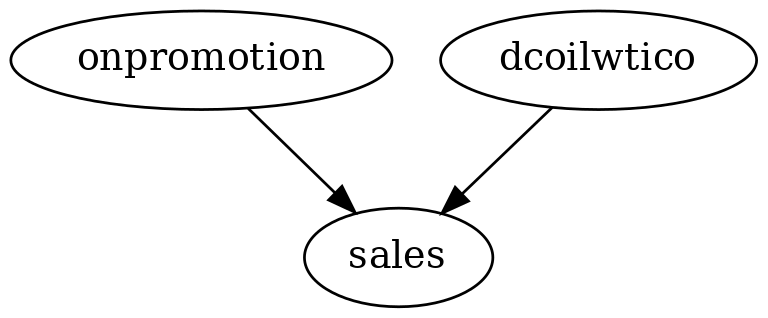

In [19]:
model= dowhy.CausalModel(
        data = df1,
        graph=causal_graph.replace("\n", " "),
        treatment="onpromotion",
        outcome='sales')
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [20]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                 
──────────────(E[sales])
d[onpromotion]          
Estimand assumption 1, Unconfoundedness: If U→{onpromotion} and U→sales then P(sales|onpromotion,,U) = P(sales|onpromotion,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [21]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression")
print(estimate)

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                 
──────────────(E[sales])
d[onpromotion]          
Estimand assumption 1, Unconfoundedness: If U→{onpromotion} and U→sales then P(sales|onpromotion,,U) = P(sales|onpromotion,)

## Realized estimand
b: sales~onpromotion+onpromotion*dcoilwtico
Target units: ate

## Estimate
Mean value: 19.907419079216197
### Conditional Estimates
__categorical__dcoilwtico
(26.189, 45.434]    28.247619
(45.434, 49.84]     25.934292
(49.84, 78.71]      23.409653
(78.71, 97.48]      12.364440
(97.48, 110.62]      9.459810
dtype: float64


In [22]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0,

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0,

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0,

In [23]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0,

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0,

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0,

In [24]:
refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0,

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0,

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['dcoilwtico']}
{'control_value': 0,

# Silly Test with another como

In [25]:
df1.head()

,sales,onpromotion,dcoilwtico
date,,,
2013-01-01,2511.618999,0,93.14
2013-01-02,496092.417944,0,93.14
2013-01-03,361461.231124,0,92.97
2013-01-04,354459.677093,0,93.12
2013-01-05,477350.121229,0,93.12


In [27]:
pd.read_csv('/home/emilien/code/EmilienStoret/favorita/Data/df_main_V4.csv') 

,id,date,store_nbr,family,sales,onpromotion,city,holidays,holidays_nat,is_holiday,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,0,1,1,93.14
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,0,1,1,93.14
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,0,1,1,93.14
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,0,1,1,93.14
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,0,1,1,93.14
...,...,...,...,...,...,...,...,...,...,...,...
3008275,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,0,0,0,47.57
3008276,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,0,0,0,47.57
3008277,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,0,0,0,47.57
3008278,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,0,0,0,47.57


In [28]:
pd.read_csv('/home/emilien/code/EmilienStoret/favorita/Data/Historic-Gold-Prices-November-2022.csv')

ParserError: Error tokenizing data. C error: Expected 3 fields in line 3, saw 4
